# Data Loading and Storage of X-ray Diffraction Patterns

The purpose of this notebook is to load and store the X-ray diffraction patterns of various materials, obtained from three different open databases: [RRUFF](https://rruff.info/about/about_general.php), the [Matminer](https://hackingmaterials.lbl.gov/matminer/) library, and the present [Materials Project](https://next-gen.materialsproject.org/) data. A total of XXX diffraction patterns were found. The data is stored in four different JSON files: three contain the materials from each database, and the last one holds the combined data for further processing.

## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
from collections import Counter
from PIL import Image

import json


#materials project
from matminer.datasets import load_dataset # !pip install matminer
from matminer.datasets import get_all_dataset_info

#pymatgen
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.analysis.diffraction.xrd import XRDCalculator

#materials project api
from mp_api.client import MPRester

It is necessary to download the XY_RAW data from this [link](https://rruff.info/zipped_data_files/powder/), and store it in the same directory as this notebook. 

In [2]:
RRUFF_df = pd.DataFrame(columns=['id' , 'source_database', 
                         'crystal_system', 'X_values', 'Y_values'])

#### Functions

The data is stored as tables in txt files. the following functions read the necessary information from these files.

In [3]:
def read_compoundname(file_name):
    #All the file names follows the format: compound__identity number__Powder__Xray_Data_XY_RAW
    regex = r'^([A-Za-z0-9-.+]+)__([A-Za-z0-9-.]+)__(\w+)'
    try:
        split_name =re.search(regex, file_name).groups()
        return split_name[0]
    except AttributeError:
        return None

In [4]:
def read_compoundid(file_name):
    #All the file names follows the format: compound__identity number__Powder__Xray_Data_XY_RAW
    regex = r'^([A-Za-z0-9-.+]+)__([A-Za-z0-9-.]+)__(\w+)'
    try:
        split_name =re.search(regex, file_name).groups()
        compound_id = split_name[0]+ '__' + split_name[1]
        return compound_id
    except AttributeError:
        return None

In [5]:
def read_crystalsys(file_path):
    try:
        content_dif = file_path.read_text(encoding="utf-8")
    except UnicodeDecodeError:  #characters that cannot be decoded using the utf-8 encoding.
        content_dif = file_path.read_text(encoding="latin1")  # or 'ISO-8859-1'.

    for line in content_dif.splitlines():
        regex = r'crystal system:\s*([A-Za-z]+)'
        if re.search(regex, line): 
            return re.search(regex, line).group(1).lower()
    return None 

In [6]:
def read_XYdata(file_path_xy):
    #Read the data from the file.
    two_theta = [] #X 
    intensity = [] #Y

    content_xy = file_path_xy.read_text(encoding="utf-8")

    for line in content_xy.splitlines():
        #If starts with 2 float numbers, then it is the 2theta, intensity data
        regex = r'^(\d+\.*\d+),\s*(\d+\.*\d+)' 
        if re.search(regex, line):
            record = re.search(regex, line).groups()
            #The first number is the 2theta angle.
            two_theta.append(float(record[0])) 
            #The second number is the intensity.
            intensity.append(float(record[1]))
            
    two_theta = np.array(two_theta)
    intensity = np.array(intensity)
    
    return two_theta, intensity
    

#### Store the diffraction data in the RRUFF DataFrame

In [7]:
# Iterate over all files in the XY directoty
path_XY = Path.cwd() / 'XY_RAW'
for index, file_path in enumerate(path_XY.glob("*.txt")):

    # Find the files's compound name
    compound_name = read_compoundname(file_path.name)
    compound_id = read_compoundid(file_path.name)

    # Find the file's crystal system and it's the corresponding directory.
    crystalsys = read_crystalsys(file_path)
    
    if crystalsys == 'rhombohedral':
        crystalsys = 'trigonal'
    
    # Find the XY data of the XRD pattern
    X, Y = read_XYdata(file_path)

    #Store the data in the dataset
    RRUFF_df.loc[index] = [compound_id, 'RUFFF', crystalsys ,  X, Y]

In [8]:
RRUFF_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3002 entries, 0 to 3001
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               3001 non-null   object
 1   source_database  3002 non-null   object
 2   crystal_system   2918 non-null   object
 3   X_values         3002 non-null   object
 4   Y_values         3002 non-null   object
dtypes: object(5)
memory usage: 140.7+ KB


In [9]:
RRUFF_df.head()

,id,source_database,crystal_system,X_values,Y_values
0,Abhurite__R060227-9,RUFFF,hexagonal,"[5.0, 5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Acanthite__R070578-9,RUFFF,monoclinic,"[5.0, 5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Acanthite__R080016-1,RUFFF,monoclinic,"[5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07, 5.0...","[62.0, 74.0, 70.0, 75.0, 75.0, 74.0, 73.0, 66...."
3,Actinolite__R040063-1,RUFFF,monoclinic,"[5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07, 5.0...","[57.0, 35.0, 47.0, 61.0, 57.0, 57.0, 66.0, 64...."
4,Actinolite__R040064-1,RUFFF,monoclinic,"[5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07, 5.0...","[31.0, 37.0, 41.0, 41.0, 40.0, 44.0, 49.0, 30...."


Capitalize the names of the crystal systems

### Missing values

In [10]:
#Null values by column
RRUFF_df.isnull().sum()

id                  1
source_database     0
crystal_system     84
X_values            0
Y_values            0
dtype: int64

In [11]:
RRUFF_df.loc[RRUFF_df.isnull().any(axis=1)].head()

,id,source_database,crystal_system,X_values,Y_values
26,AeschyniteY__R060312-1,RUFFF,None,"[5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07, 5.0...","[18.0, 23.0, 26.0, 20.0, 19.0, 26.0, 25.0, 20...."
67,AllaniteCe__R080092-1,RUFFF,None,"[5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07, 5.0...","[51.0, 46.0, 52.0, 52.0, 62.0, 67.0, 55.0, 57...."
96,Amber__R060569-1,RUFFF,None,"[5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07, 5.0...","[44.0, 56.0, 70.0, 61.0, 63.0, 40.0, 54.0, 78...."
142,Anilite__R060688-9,RUFFF,None,"[6.0, 6.03, 6.06, 6.09, 6.12, 6.15, 6.18, 6.21...","[147.176, 148.506, 151.494, 149.956, 149.227, ..."
157,Anorthite__R070598-1,RUFFF,None,"[5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07, 5.0...","[63.0, 35.0, 63.0, 62.0, 49.0, 44.0, 49.0, 43...."


The elements without a crystal system are amorphous materials, like glass.Therefore, they should be deleted.

In [12]:
RRUFF_df = RRUFF_df.replace({None: np.nan})
RRUFF_df.dropna(inplace=True)
RRUFF_df.isna().sum()

id                 0
source_database    0
crystal_system     0
X_values           0
Y_values           0
dtype: int64

### Crystal Systems Present in the RRUFF Dataset

In [13]:
RRUFF_crystalsys = RRUFF_df.groupby('crystal_system')['id'].count()
RRUFF_crystalsys

crystal_system
cubic           302
hexagonal       513
monoclinic      960
orthorhombic    610
tetragonal      218
triclinic       293
trigonal         19
unknown           2
Name: id, dtype: int64

### Capitalize the names of the crystal systems

In [14]:
RRUFF_df['crystal_system'] = RRUFF_df['crystal_system'].apply(lambda x: x.capitalize())

### Delete the materials with an unknown crystal system

In [15]:
unknown_crysys = RRUFF_df[RRUFF_df['crystal_system']=='Unknown']
unknown_crysys

,id,source_database,crystal_system,X_values,Y_values
10,Adachiite__R230014-9,RUFFF,Unknown,"[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1051,Fluorcarletonite__R180028,RUFFF,Unknown,"[3.0, 3.02, 3.04, 3.06, 3.08, 3.1, 3.12, 3.14,...","[1601.0, 1548.0, 1588.0, 1519.0, 1502.0, 1525...."


In [16]:
RRUFF_df.drop(unknown_crysys.index, inplace=True)

### Materials per Crystal system

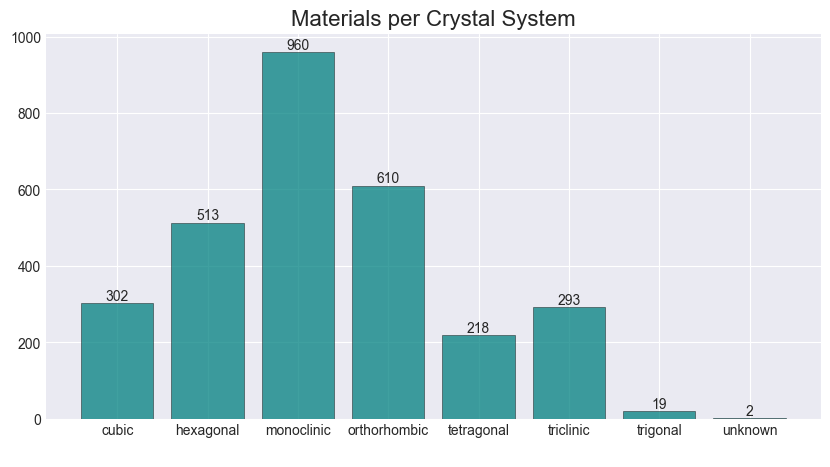

In [17]:
plt.style.use('seaborn-v0_8-dark')

# Bar plot
fig, ax = plt.subplots(figsize=(10,5))


bar_container = ax.bar(RRUFF_crystalsys.index, 
                       RRUFF_crystalsys.values,
                       edgecolor = 'k', 
                       align='center',
                       linewidth= 0.4,
                       alpha=0.75,
                       color='teal')

ax.set_title('Materials per Crystal System', fontsize=16)
ax.set_ylabel('')
ax.set_xlabel(' ')
ax.bar_label(bar_container, fmt='{:,.0f}')

#plt.tight_layout()
plt.grid()
plt.show()
plt.style.use('default')

In [19]:
RRUFF_df['X_values'][0]

array([ 5.  ,  5.01,  5.02, ..., 89.98, 89.99, 90.  ])

### Save the dataframe

In [20]:
RRUFF_df.to_json("RRUFF.json")

# Load the Matminer data

In [21]:
#mp_all_20181018
matminer_df = load_dataset("mp_all_20181018") 

### Examine the data

In [22]:
#Print the dataset doc 
print(get_all_dataset_info("mp_all_20181018"))

Dataset: mp_all_20181018
Description: A complete copy of the Materials Project database as of 10/18/2018. mp_all files contain structure data for each material while mp_nostruct does not.
Columns:
	bulk modulus: in GPa, average of Voight, Reuss, and Hill
	e_form: Formation energy per atom (eV)
	e_hull: The calculated energy above the convex hull, in eV per atom
	elastic anisotropy: The ratio of elastic anisotropy.
	formula: The chemical formula of the MP entry
	gap pbe: The band gap in eV calculated with PBE-DFT functional
	initial structure: A Pymatgen Structure object describing the material crystal structure prior to relaxation
	mpid: (input): The Materials Project mpid, as a string.
	mu_b: The total magnetization of the unit cell.
	shear modulus: in GPa, average of Voight, Reuss, and Hill
	structure: A Pymatgen Structure object describing the material crystal structure
Num Entries: 83989
Reference: A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gun

In [23]:
matminer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83989 entries, 0 to 83988
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mpid                83989 non-null  object 
 1   formula             83987 non-null  object 
 2   e_hull              83989 non-null  float64
 3   gap pbe             83989 non-null  float64
 4   mu_b                83989 non-null  float64
 5   elastic anisotropy  7676 non-null   float64
 6   bulk modulus        7676 non-null   float64
 7   shear modulus       7676 non-null   float64
 8   structure           83989 non-null  object 
 9   e_form              83989 non-null  float64
 10  initial structure   83989 non-null  object 
dtypes: float64(7), object(4)
memory usage: 7.7+ MB


In [24]:
matminer_df.head()

,mpid,formula,e_hull,gap pbe,mu_b,elastic anisotropy,bulk modulus,shear modulus,structure,e_form,initial structure
0,mp-85,In,0.003319,0.0000,2.700000e-05,1.044699,33.154748,4.904836,[[0. 0. 0.] In],0.003319,[[0. 0. 0.] In]
1,mp-110,Mg,0.039182,0.0000,-1.360000e-05,-11.326659,35.636106,1.830272,[[0. 0. 0.] Mg],0.039182,[[0. 0. 0.] Mg]
2,mp-20,Be,0.108143,0.0000,1.000000e-07,8.030000,124.000000,84.000000,"[[0.63178657 0.88038073 0.88034747] Be, [1.895...",0.108143,"[[0.71544 1.0248 0.6759 ] Be, [1.79944 2.3912..."
3,mp-8640,Hf,0.071216,0.0000,-2.050000e-05,0.881277,101.242732,44.836516,[[0. 0. 0.] Hf],0.071216,[[0. 0. 0.] Hf]
4,mp-674158,P,3.509988,2.0113,3.000042e+00,10.884643,0.327165,-0.064038,[[0. 0. 0.] P],3.509988,[[0. 0. 0.] P]


### Filter the Data

Keep only the "id" and "structure" columns. The structure is a pymatgen object, that is used to calculate the crystal system and the X-ray diffraction pattern data.

In [25]:
matminer_df = matminer_df[['mpid', 'structure']] 

In [26]:
matminer_df.head()

,mpid,structure
0,mp-85,[[0. 0. 0.] In]
1,mp-110,[[0. 0. 0.] Mg]
2,mp-20,"[[0.63178657 0.88038073 0.88034747] Be, [1.895..."
3,mp-8640,[[0. 0. 0.] Hf]
4,mp-674158,[[0. 0. 0.] P]


### Missing values

In [27]:
#Null values by column
matminer_df.isnull().sum()

mpid         0
structure    0
dtype: int64

In [28]:
matminer_df.isna().sum()

mpid         0
structure    0
dtype: int64

### Calculate the crystal system

In [23]:
def find_crystalsystem(structure):
    calculator = SpacegroupAnalyzer(structure)
   
    return calculator.get_crystal_system()  

In [30]:
matminer_df['crystal_system'] = matminer_df['structure'].apply(find_crystalsystem)

### Capitalize the names of the crystal systems 

In [35]:
matminer_df['crystal_system'] = matminer_df['crystal_system'].apply(lambda x: x.capitalize())

### Calculate the XY diffraction data

In [22]:
def find_pattern(structure):
    #calculate and store the X-Ray powder diffraction as a 2theta- Intensity table.
    # Use the conventional structure to ensure peaks are labeled correctly
    sga = SpacegroupAnalyzer(structure)
    conventional_structure = sga.get_conventional_standard_structure()
    
    # Generate the XRD diffraction pattern
    calculator = XRDCalculator(wavelength="CuKa")
    
    return calculator.get_pattern(conventional_structure)

**Note:** I had to do this with a loop because otherwise, it would never finish.

In [32]:
X=[]
Y=[]
for index in range(matminer_df.shape[0]):
    material = matminer_df.loc[index]
    pattern = find_pattern(material.structure)
    X.append(pattern.x)
    Y.append(pattern.y)

C:\Users\juliana\anaconda3\Lib\site-packages\pymatgen\core\periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
C:\Users\juliana\anaconda3\Lib\site-packages\pymatgen\core\periodic_table.py:289: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
C:\Users\juliana\anaconda3\Lib\site-packages\pymatgen\core\periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
C:\Users\juliana\anaconda3\Lib\site-packages\pymatgen\core\periodic_table.py:289: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done

In [33]:
matminer_df['X_values'] = X

In [34]:
matminer_df['Y_values'] = Y

### Materials per Crystal system

In [3]:
matminer_df = pd.read_json('matminer.json')

In [4]:
matminer_crystalsys = matminer_df.groupby('crystal_system')['mpid'].count()
matminer_crystalsys

crystal_system
Cubic           10737
Hexagonal        6066
Monoclinic      18814
Orthorhombic    18799
Tetragonal      10508
Triclinic       12078
Trigonal         6987
Name: mpid, dtype: int64

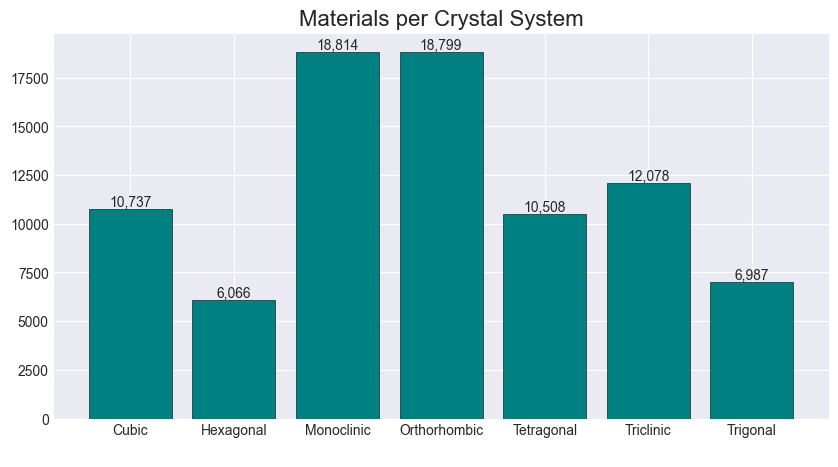

In [7]:
plt.style.use('seaborn-v0_8-dark')

# Bar plot
fig, ax = plt.subplots(figsize=(10,5))


bar_container = ax.bar(matminer_crystalsys.index, 
                       matminer_crystalsys.values,
                       edgecolor = 'k', 
                       align='center',
                       linewidth= 0.4,
                       color='teal')

ax.set_title('Materials per Crystal System', fontsize=16)
ax.set_ylabel('')
ax.set_xlabel(' ')
ax.bar_label(bar_container, fmt='{:,.0f}')

#plt.tight_layout()
plt.grid()
plt.show()
plt.style.use('default')

### Store the matminer data 

In [44]:
matminer_df.columns

Index(['mpid', 'structure', 'crystal_system', 'X_values', 'Y_values'], dtype='object')

In [46]:
tmp = matminer_df.drop(columns=['structure'])

In [47]:
tmp.to_json("matminer.json")

# Load the materials project data

Request 1,000 materials from the hexagonal and trigonal crystal systems through the Materials Project API. These systems have fewer materials, and I was only able to request 1,000.
You can find the Materials Project documentation [here](https://docs.materialsproject.org/).

In [8]:
mp_df = pd.DataFrame(columns=['mpid', 'crystal_system', 'X_values', 'Y_values'])

In [9]:
#KEY to the materials project API
API_KEY = "VWWqWZsn3v6LQFwqnWEwYc4vVj119EHl"

In [10]:
def get_mp_data(crystal_system, size, API_KEY = API_KEY):
    with MPRester(API_KEY) as mpr:
        docs = mpr.materials.summary.search(crystal_system = crystal_system, 
                                            num_chunks =1, 
                                            chunk_size=size,
                                            fields=['material_id', 'symmetry', 
                                                  'structure'])
    return docs

In [11]:
materials_hexagonal = get_mp_data('Hexagonal', 1000)

Retrieving SummaryDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
materials_trigonal = get_mp_data('Trigonal', 1000)

Retrieving SummaryDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
materials_tetragonal = get_mp_data('Tetragonal', 1000)

Retrieving SummaryDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
materials_cubic = get_mp_data('Cubic', 1000)

Retrieving SummaryDoc documents:   0%|          | 0/1000 [00:00<?, ?it/s]

### Store the data in the materials project dataframe

In [20]:
def add_mp_data(data, target_df):
    size_df = target_df.shape[0]
    for i, material in enumerate(data):
        mpid = material.material_id
        crystal_sys = str(material.symmetry.crystal_system).capitalize()

        pattern = find_pattern(material.structure)

        x_values = pattern.x
        y_values = pattern.y

        target_df.loc[i + size_df] = [mpid, crystal_sys, 
                                      x_values, y_values]

In [24]:
add_mp_data(materials_hexagonal, mp_df)
add_mp_data(materials_trigonal, mp_df)
add_mp_data(materials_tetragonal, mp_df)
add_mp_data(materials_cubic, mp_df)

C:\Users\juliana\anaconda3\Lib\site-packages\pymatgen\core\periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
C:\Users\juliana\anaconda3\Lib\site-packages\pymatgen\core\periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


### Save the materials project data

In [25]:
mp_df.to_json("mp.json")

# Join the Datasets

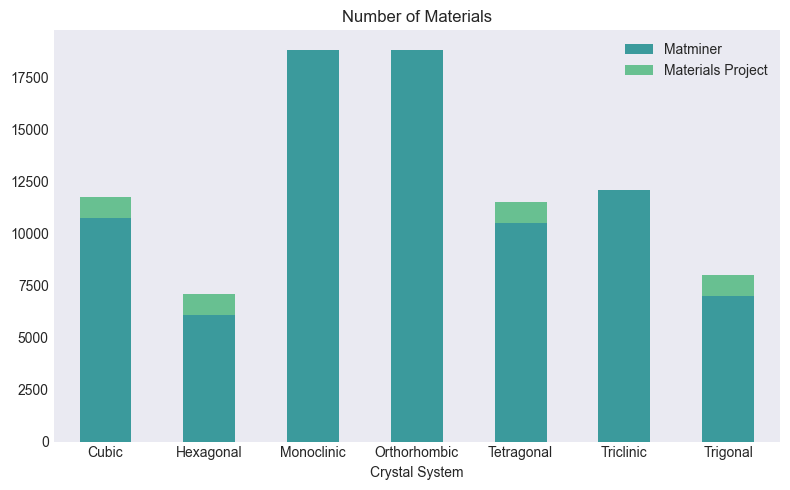

In [27]:
plt.style.use('seaborn-v0_8-dark')
num_matminer = matminer_df.groupby('crystal_system')['mpid'].count()
num_mp = mp_df.groupby('crystal_system')['mpid'].count()
index = num_matminer.index

df = pd.DataFrame({'Matminer': num_matminer,
                  'Materials Project': num_mp}, index=index)

fig, ax = plt.subplots(figsize=(8, 5))
df.plot.bar(rot=0, stacked=True, 
            color= ['teal', 'mediumseagreen'],alpha=0.75,
            ax = ax)
ax.set(title='Number of Materials', xlabel='Crystal System')
plt.tight_layout()

### concatenate the dataframes

In [28]:
# Change the column names so they match
matminer_df.rename(columns={'mpid': 'id'}, inplace=True)
mp_df.rename(columns={'mpid': 'id'}, inplace=True)

# Add source database column
matminer_df['source_database'] = 'Matminer'
mp_df['source_database'] = 'mp'

In [30]:
dataset = pd.concat([matminer_df, mp_df], 
                   ignore_index=True)


### Dataset information

In [31]:
dataset.head()

,id,crystal_system,X_values,Y_values,source_database
0,mp-85,Tetragonal,"[32.3536089071, 36.3520663769, 38.1099360092, ...","[100.0, 18.1958586805, 31.8782768858, 22.91688...",Matminer
1,mp-110,Cubic,"[35.4679954588, 51.0324956984, 63.6841425788, ...","[100.0, 16.976374379, 33.5918902393, 9.9493066...",Matminer
2,mp-20,Cubic,"[51.6585266924, 76.0725042731]","[100.0, 17.5068706603]",Matminer
3,mp-8640,Cubic,"[34.6695349659, 40.2473671921, 58.2290835966, ...","[100.0, 49.9874745409, 34.2603160603, 40.33535...",Matminer
4,mp-674158,Cubic,"[19.5279458907, 22.5859010533, 32.1552064177, ...","[100.0, 51.0568207953, 37.3581324298, 45.40608...",Matminer


In [32]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87989 entries, 0 to 87988
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               87989 non-null  object
 1   crystal_system   87989 non-null  object
 2   X_values         87989 non-null  object
 3   Y_values         87989 non-null  object
 4   source_database  87989 non-null  object
dtypes: object(5)
memory usage: 3.4+ MB


In [33]:
dataset.isnull().sum()

id                 0
crystal_system     0
X_values           0
Y_values           0
source_database    0
dtype: int64

### Materials per Crystal System

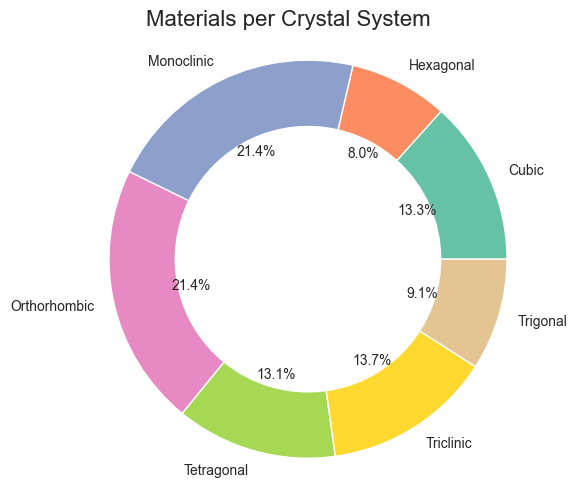

In [34]:
crystal_sys = dataset.groupby('crystal_system')['id'].count()

# Donut plot
fig, ax = plt.subplots(figsize=(6,5))

# create a color palette, mapped to these values
Set2 = plt.color_sequences["Set2"]
colors = [Set2[i] for i in range(crystal_sys.size)]

ax.pie(crystal_sys.values, 
       radius=1.5, 
       colors=colors,
       labels= crystal_sys.index, 
       wedgeprops=dict(width= 0.5, edgecolor='w'),
      autopct = '%1.1f%%')

fig.suptitle('Materials per Crystal System', fontsize=16)
plt.tight_layout()
plt.show()
plt.style.use('default')

### Save dataset

In [35]:
dataset.to_json("dataseV2.json")

KeyboardInterrupt: 